## Setup

In [ ]:
!pip install -U -q "google-generativeai>=0.8.2" pandas==2.2.2 python-dotenv matplotlib spacy transformers torch

Cloning into 'nlp-stat-draw-intern'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 51 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 136.85 KiB | 1.20 MiB/s, done.
Resolving deltas: 100% (21/21), done.


Enter your query: which contry bought more cars
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORDERNUMBER           2747 non-null   int64  
 1   QUANTITYORDERED       2747 non-null   int64  
 2   PRICEEACH             2747 non-null   float64
 3   ORDERLINENUMBER       2747 non-null   int64  
 4   SALES                 2747 non-null   float64
 5   ORDERDATE             2747 non-null   object 
 6   DAYS_SINCE_LASTORDER  2747 non-null   int64  
 7   STATUS                2747 non-null   object 
 8   PRODUCTLINE           2747 non-null   object 
 9   MSRP                  2747 non-null   int64  
 10  PRODUCTCODE           2747 non-null   object 
 11  CUSTOMERNAME          2747 non-null   object 
 12  PHONE                 2747 non-null   object 
 13  ADDRESSLINE1          2747 non-null   object 
 14  CITY                  27

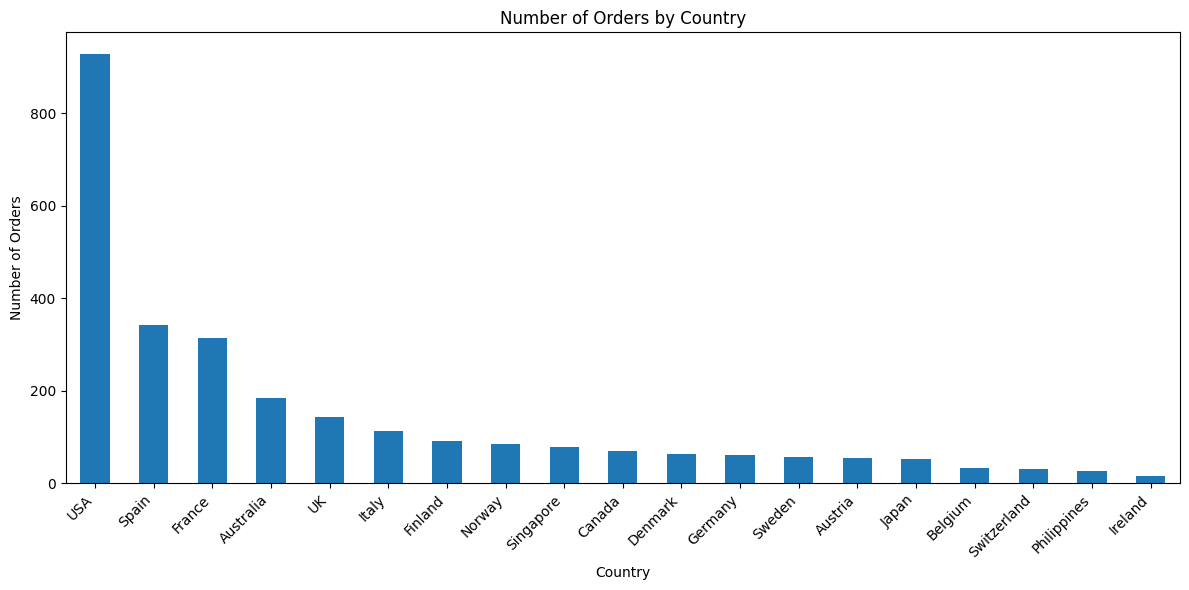

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ncsv_path = '/content/data.csv'\ndf = pd.read_csv(csv_path)\n\ncountry_counts = df['COUNTRY'].value_counts()\nplt.figure(figsize=(12, 6))\ncountry_counts.plot(kind='bar')\nplt.title('Number of Orders by Country')\nplt.xlabel('Country')\nplt.ylabel('Number of Orders')\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n\n```\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "citation_metadata": {
            "citation_sources": [
              {
                "start_index": 228,
                "end_index": 361,
                "uri": "https://github.com/abhinav310199/Predicting-drug-response-using-deep-le

In [ ]:
import os
import google.generativeai as genai
import pandas as pd
import runpy
from dotenv import load_dotenv
import spacy
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch



load_dotenv()
KEY=os.getenv('KEY')

genai.configure(api_key=KEY)
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)

chat_session = model.start_chat(
  history=[
  ]
)
csv_path = 'data.csv'
dataset = pd.read_csv(csv_path)
dataset_str = dataset.head(20).to_string(index=False)
user_query = input("Enter your query: ")


nlp = spacy.load("en_core_web_sm")

model = RobertaForSequenceClassification.from_pretrained("./trained_roberta")
tokenizer = RobertaTokenizer.from_pretrained("./trained_roberta")

def extract_keywords_and_predict_graph_requirement(query):
    doc = nlp(query)

    keywords = []
    for token in doc:
        if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
            keywords.append(token.text)

    inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    graph_requirement = "needed" if prediction == 1 else "not needed"

    return keywords, graph_requirement

keywords_query, graph_flag_query = extract_keywords_and_predict_graph_requirement(user_query)


query = f"""
dataset insights:
{dataset.info()}
{dataset.describe(include='all')}

Dataset:
{dataset_str}

query: "{user_query}"
graph/visual_representation: {graph_flag_query} (generate python matplotlib code acoordinglly)
Use keywords: {keywords_query} to estimate the type of graph.


NOTE:Do not include citations or sources and decorative explanations.
Just return the code.
Full dataset available at 'csv_path = 'data.csv'
"""

response = chat_session.send_message(query)

fh = open("plt.py", "w")
fo = response.text
fo = fo.replace("```python", "\n").replace("```", "\n")
fh.write(fo)
fh.close()
runpy.run_path('plt.py')


print(response.text)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />Docs on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-gemini/cookbook/blob/main/quickstarts"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />More notebooks in the Cookbook</a>
  </td>
</table>

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import csv

with open('train_data.csv', mode='r') as file:
    reader = csv.DictReader(file)
    data = []

    for row in reader:
        query = row['query']
        keywords = row['keywords']
        graph_requirement = row['graph_requirement']

        data.append({
            "query": query,
            "keywords": keywords,
            "graph_requirement": graph_requirement
        })




formatted_data = {
    "query": [item["query"] for item in data],
    "keywords": [item["keywords"] for item in data],
    "graph_requirement": [item["graph_requirement"] for item in data],
}
dataset = Dataset.from_dict(formatted_data)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["query"], padding=True, truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset.map(
    lambda x: {"labels": [1 if label == "needed" else 0 for label in x["graph_requirement"]]},
    batched=True
)


train_dataset, test_dataset = encoded_dataset.train_test_split(test_size=0.2).values()
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

model.save_pretrained("./trained_roberta")
tokenizer.save_pretrained("./trained_roberta")
